In [1]:
from jqdata import *
from jqfactor import (get_factor_values,
                      calc_factors,
                      Factor)
import talib
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.optimize import minimize
 
from tqdm import tqdm_notebook
from dateutil.parser import parse

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.style.use('seaborn')

In [2]:
class EPTTM(Factor):
    
    name = 'EPTTM'
    max_window = 1
    dependencies = ['pe_ratio']
    
    def calc(self,data):
        
        return (1 / data['pe_ratio']).iloc[0]
    
class SPTTM(Factor):
    
    name = 'SPTTM'
    max_window = 1
    dependencies = ['ps_ratio']
    
    def calc(self,data):
        
        return (1 / data['ps_ratio']).iloc[0]
    

class SUE0(Factor):

    '''含漂移项'''

    name = 'SUE0'
    max_window = 1

    global fields

    fields = [f'net_profit_{i}' if i != 0 else 'net_profit' for i in range(9)]

    dependencies = fields

    def calc(self, data):

        # 数据结构为 columns为 net_profit至net_profit_8
        df = pd.concat([v.T for v in data.values()], axis=1)
        df.columns = fields
        df.fillna(0, inplace=True)

        # 漂移项可以根据过去两年盈利同比变化Q{i,t} - Q{i,t-4}的均值估计
        # 数据结构为array
        tmp = df.iloc[:, 1:5].values - df.iloc[:, 5:].values

        C = np.mean(tmp, axis=1)  # 漂移项 array

        epsilon = np.std(tmp, axis=1)  # 残差项epsilon array

        Q = df.iloc[:, 4] + C + epsilon  # 带漂移项的季节性随机游走模型

        return (df.iloc[:, 0] - Q) / epsilon
    
class SUR0(Factor):

    '''含漂移项'''

    name = 'SUR0'
    max_window = 1

    global fields

    fields = [f'operating_revenue_{i}' if i !=
              0 else 'operating_revenue' for i in range(9)]

    dependencies = fields

    def calc(self, data):

        # 数据结构为 columns为 net_profit至net_profit_8
        df = pd.concat([v.T for v in data.values()], axis=1)
        df.columns = fields
        df.fillna(0, inplace=True)

        # 漂移项可以根据过去两年盈利同比变化Q{i,t} - Q{i,t-4}的均值估计
        # 数据结构为array
        tmp = df.iloc[:, 1:5].values - df.iloc[:, 5:].values

        C = np.mean(tmp, axis=1)  # 漂移项 array

        epsilon = np.std(tmp, axis=1)  # 残差项epsilon array

        Q = df.iloc[:, 4] + C + epsilon  # 带漂移项的季节性随机游走模型

        return (df.iloc[:, 0] - Q) / epsilon
    
class DELTAROE(Factor):
    
    '''单季度净资产收益率-去年同期单季度净资产收益率'''
    
    name = 'DELTAROE'
    max_window = 1
    dependencies = ['roe','roe_4']
    
    def calc(self,data):
        
        return (data['roe'] - data['roe_4']).iloc[0]
    
class DELTAROA(Factor):
    
    '''单季度总资产收益率-去年同期单季度中资产收益率'''
    
    name = 'DELTAROA'
    max_window = 1
    dependencies = ['roa','roa_4']
    
    def calc(self,data):
        
        
        return (data['roa'] - data['roa_4']).iloc[0]
    
class ILLIQ(Factor):
    
    name = 'ILLIQ'
    max_window = 21
    dependencies = ['close','money']
    
    def calc(self,data):
        
        abs_ret = np.abs(data['close'].pct_change().shift(1).iloc[1:])
        
        return (abs_ret / data['money'].iloc[1:]).mean()
    

    
class ATR3M(Factor):
    
    '''过去60个交易日日内真实波幅均值'''
    name = 'ATR3M'
    max_window = 62
    dependencies = ['close','high','low']
    
    def calc(self,data):
        
        HIGH = data['high'].shift(1).iloc[1:]
        LOW = data['low'].shift(1).iloc[1:]
        CLOSE = data['close'].shift(1).iloc[1:]
        
        tmp = np.maximum(HIGH - LOW,np.abs(CLOSE.shift(1) - HIGH))
        TR = np.maximum(tmp,np.abs(CLOSE.shift(1) - LOW))
    
        return TR.iloc[-60:].mean()

In [3]:
# 筛选成分股 

class FilterStocks(object):
    '''
    获取某日的成分股股票
    1. 过滤st
    2. 过滤上市不足N个月
    3. 过滤当月交易不超过N日的股票
    ---------------
    输入参数：
        index_symbol:指数代码,A约等于全市场,800是设置的HS300+ZZ500
        watch_date:日期
        N:上市不足N月
        active_day:过滤交易不足N日的股票
    '''

    def __init__(self, index_symbol: str, watch_date: str, N: int = 3, active_day: int = 15):

        self.__index_symbol = index_symbol
        self.__watch_date = parse(watch_date).date()
        self.__N = N  # 过滤上市不足N月股票
        self.__active_day = active_day  # 交易日期

    # 获取并过滤成分股 

    # 获取股票池
    @property
    def Get_Stocks(self) -> list:
        '''
        bar_datetime:datetime.date
        '''

        if self.__index_symbol == 'A':

            stockList = get_index_stocks('000002.XSHG', date=self.__watch_date) + get_index_stocks(
                '399107.XSHE', date=self.__watch_date)

        else:
            stockList = get_index_stocks(
                self.__index_symbol, date=self.__watch_date)

        # 过滤ST
        st_data = get_extras(
            'is_st', stockList, end_date=self.__watch_date, count=1).iloc[0]

        stockList = st_data[st_data == False].index.tolist()

        # 剔除停牌、新股及退市股票
        stockList = self.delect_stop(stockList, self.__watch_date, self.__N)

        # 近15日均有交易的股票
        active_stock = self.delect_pause(
            stockList, self.__watch_date, self.__active_day)

        return active_stock

    # 去除上市距beginDate不足 3 个月的股票
    @staticmethod
    def delect_stop(stocks: list, beginDate: datetime.date,
                    n: int = 30 * 3) -> list:

        return [
            code for code in stocks
            if get_security_info(code).start_date < (beginDate -
                                                     datetime.timedelta(days=n))
        ]

    # 近15日内有交易
    @staticmethod
    def delect_pause(stocks: list, beginDate: datetime.date, n: int = 15) -> list:

        beginDate = get_trade_days(end_date=beginDate, count=1)[
            0].strftime('%Y-%m-%d')

        # 获取过去22日的交易数据
        df = get_price(
            stocks, end_date=beginDate, count=22, fields='paused', panel=False)

        # 当日交易
        t_trade = df.query('paused==0 and time==@beginDate')[
            'code'].values.tolist()

        # 当日交易 且 15日都有交易记录
        total_num = df[df['code'].isin(t_trade)].groupby('code')[
            'paused'].sum()

        return total_num[total_num < n].index.tolist()

In [4]:
def get_factor(func, index_symbol: str, start: str, end: str, freq: str = 'ME') -> pd.DataFrame:
    
    '''
    因子获取
    ---------
        func:为因子获取函数
        index_symbol:成分股代码
        freq:日期频率
    '''

    periods = GetTradePeriod(start, end, freq)

    factor_dic = {}
    for d in tqdm_notebook(periods):

        securities = FilterStocks(
            index_symbol, d.strftime('%Y-%m-%d'), N=12).Get_Stocks
        factor_dic[d] = func(securities, d)

    factor_df = pd.concat(factor_dic)
    factor_df.index.names = ['date', 'code']

    return factor_df

# 获取年末季末时点

def GetTradePeriod(start_date: str, end_date: str, freq: str = 'ME') -> list:
    '''
    start_date/end_date:str YYYY-MM-DD
    freq:M月，Q季,Y年 默认ME E代表期末 S代表期初
    ================
    return  list[datetime.date]
    '''
    days = pd.Index(pd.to_datetime(get_trade_days(start_date, end_date)))
    idx_df = days.to_frame()

    if freq[-1] == 'E':
        day_range = idx_df.resample(freq[0]).last()
    else:
        day_range = idx_df.resample(freq[0]).first()

    day_range = day_range[0].dt.date

    return day_range.dropna().values.tolist()


def query_model1_factor(securities: list, watch_date: str) -> pd.DataFrame:
    
    import warnings
    warnings.filterwarnings("ignore")
    
    fields = ['operating_profit_per_share_ttm',
              'retained_earnings','total_profit_ttm','EBITDA','VOL240','sharpe_ratio_60']

    part_a = get_factor_values(
        securities, fields, start_date=watch_date, end_date=watch_date)
    part_a = dict2frame(part_a)

    # 自定义因子
    fields = [EPTTM(), SPTTM(), SUE0(),SUR0(), DELTAROE(), DELTAROA(),
              ILLIQ(), ATR3M()]

    part_b = calc_factors(securities, fields,
                          start_date=watch_date, end_date=watch_date)
    part_b = dict2frame(part_b)

    # 辅助项
    part_c = IndusrtyMktcap(securities, watch_date)

    factor_df = pd.concat([part_a, part_b, part_c], axis=1)

    return factor_df


def dict2frame(dic: dict) -> pd.DataFrame:
    
    '''将data的dict格式转为df'''

    tmp_v = [v.T for v in dic.values()]
    name = [k.upper() for k in dic.keys()]

    df = pd.concat(tmp_v, axis=1)
    df.columns = name

    return df


def IndusrtyMktcap(securities: list, watch_date: str) -> pd.DataFrame:
    
    '''增加辅助 行业及市值'''

    #indusrty_dict = get_industry(securities, watch_date)

    #indusrty_ser = pd.Series({k: v.get('sw_l1', {'industry_code': np.nan})[
    #                        'industry_code'] for k, v in indusrty_dict.items()})

    #indusrty_ser.name = 'INDUSTRY_CODE'
    
    industry_ser = get_stock_ind(securities,watch_date)
    
    mkt_cap = get_valuation(securities, end_date=watch_date,
                            fields='market_cap', count=1).set_index('code')['market_cap']
    
    return pd.concat([industry_ser, mkt_cap], axis=1)


def get_stock_ind(securities:list,watch_date:str,level:str='sw_l1',method:str='industry_code')->pd.Series:
    
    '''
    获取行业
    --------
        securities:股票列表
        watch_date:查询日期
        level:查询股票所属行业级别
        method:返回行业名称or代码
    '''
    
    indusrty_dict = get_industry(securities, watch_date)

    indusrty_ser = pd.Series({k: v.get('sw_l1', {method: np.nan})[
                             method] for k, v in indusrty_dict.items()})
    
    indusrty_ser.name = method.upper()
    
    return indusrty_ser

In [5]:
# 设置时间范围
START_DATE = '2013-01-01'
END_DATE = '2023-09-30'

In [6]:
# 因子获取
factors = get_factor(query_model1_factor,'000300.XSHG',START_DATE,END_DATE)
# 因子储存
factors.to_csv('index_enhancement.csv')

In [7]:
# 因子读取
factors = pd.read_csv('index_enhancement.csv',index_col=[0,1],parse_dates=[0],dtype={'INDUSTRY_CODE':str})

# 查看数据结构
factors.head()

TOTAL_PROFIT_TTM     ...      market_cap
date       code                              ...                
2013-01-31 000001.XSHE      1.674516e+10     ...       1081.0269
           000002.XSHE      1.832167e+10     ...       1320.5247
           000009.XSHE      3.461996e+08     ...        105.9119
           000012.XSHE      7.212089e+08     ...        179.7241
           000024.XSHE      5.224399e+09     ...        490.8045

[5 rows x 16 columns]

In [8]:
# step1:构建缺失值处理函数
def factors_null_process(data: pd.DataFrame) -> pd.DataFrame:

    # 删除行业缺失值
    data = data[data['INDUSTRY_CODE'].notnull()]
    # 变化索引，以行业为第一索引，股票代码为第二索引
    data_ = data.reset_index().set_index(
        ['INDUSTRY_CODE', 'code']).sort_index()
    # 用行业中位数填充
    data_ = data_.groupby(level=0).apply(
        lambda factor: factor.fillna(factor.median()))
    
    # 有些行业可能只有一两个个股却都为nan此时使用0值填充
    data_ = data_.fillna(0)
    # 将索引换回
    data_ = data_.reset_index().set_index('code').sort_index()
    return data_.drop('date', axis=1)

In [9]:
# step2:构建绝对中位数处理法函数
def extreme_process_MAD(data: pd.DataFrame, num: int = 3) -> pd.DataFrame:
    ''' data为输入的数据集，如果数值超过num个判断标准则使其等于num个标准'''

    # 为不破坏原始数据，先对其进行拷贝
    data_ = data.copy()

    # 获取数据集中需测试的因子名
    feature_names = [i for i in data_.columns.tolist() if i not in [
        'INDUSTRY_CODE','market_cap']]

    # 获取中位数
    median = data_[feature_names].median(axis=0)
    # 按列索引匹配，并在行中广播
    MAD = abs(data_[feature_names].sub(median, axis=1)
              ).median(axis=0)
    # 利用clip()函数，将因子取值限定在上下限范围内，即用上下限来代替异常值
    data_.loc[:, feature_names] = data_.loc[:, feature_names].clip(
        lower=median-num * 1.4826 * MAD, upper=median + num * 1.4826 * MAD, axis=1)
    return data_

In [10]:
##step3:构建标准化处理函数
def data_scale_Z_Score(data: pd.DataFrame) -> pd.DataFrame:

    # 为不破坏原始数据，先对其进行拷贝
    data_ = data.copy()
    # 获取数据集中需测试的因子名
    feature_names = [i for i in data_.columns.tolist() if i not in [
        'INDUSTRY_CODE','market_cap']]
    data_.loc[:, feature_names] = (
        data_.loc[:, feature_names] - data_.loc[:, feature_names].mean()) / data_.loc[:, feature_names].std()
    return data_

In [11]:
# step4:因子中性化处理函数
def neutralization(data: pd.DataFrame) -> pd.DataFrame:
    
    '''按市值、行业进行中性化处理 ps:处理后无行业市值信息'''
    factor_name = [i for i in data.columns.tolist() if i not in [
        'INDUSTRY_CODE', 'market_cap']]
    
    # 回归取残差
    def _calc_resid(x: pd.DataFrame, y: pd.Series) -> float:

        result = sm.OLS(y, x).fit()

        return result.resid
    
    X = pd.get_dummies(data['INDUSTRY_CODE'])
    # 总市值单位为亿元
    X['market_cap'] = np.log(data['market_cap'] * 100000000)
    
    df = pd.concat([_calc_resid(X.fillna(0), data[i])
                    for i in factor_name], axis=1)
    
    df.columns = factor_name
    
    df['INDUSTRY_CODE'] = data['INDUSTRY_CODE']
    df['market_cap'] = data['market_cap']
    
    return df

In [12]:
## 其实可以直接pipe处理但是这里为了后续灵活性没有选择pipe化

# 去极值
factors1 = factors.groupby(level='date').apply(extreme_process_MAD)
# 缺失值处理
factors2 = factors1.groupby(level='date').apply(factors_null_process)
# 中性化
factors3 = factors2.groupby(level='date').apply(neutralization)
# 标准化
factors4 = factors3.groupby(level='date').apply(data_scale_Z_Score)

In [13]:
print(factors.info())
print('去缺失值:')
print(factors2.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37664 entries, (2013-01-31 00:00:00, 000001.XSHE) to (2023-09-28 00:00:00, 688981.XSHG)
Data columns (total 16 columns):
TOTAL_PROFIT_TTM                  37472 non-null float64
EBITDA                            37664 non-null float64
SHARPE_RATIO_60                   37658 non-null float64
RETAINED_EARNINGS                 37573 non-null float64
VOL240                            37664 non-null float64
OPERATING_PROFIT_PER_SHARE_TTM    37377 non-null float64
EPTTM                             37659 non-null float64
SPTTM                             37659 non-null float64
SUE0                              37660 non-null float64
SUR0                              37660 non-null float64
DELTAROE                          37018 non-null float64
DELTAROA                          37018 non-null float64
ILLIQ                             37664 non-null float64
ATR3M                             37664 non-null float64
INDUSTRY_CODE                  

In [14]:
## step5:构建对称正交变换函数
def lowdin_orthogonal(data:pd.DataFrame)->pd.DataFrame:

    data_ = data.copy() # 创建副本不影响原数据
    col = [col for col in data_.columns if col not in ['INDUSTRY_CODE','market_cap']]
    
    F = np.mat(data_[col])  # 除去行业指标,将数据框转化为矩阵
    M = F.T @ F # 等价于 (F.shape[0] - 1) * np.cov(F.T)
    a,U = np.linalg.eig(M)  # a为特征值，U为特征向量
    D_inv = np.linalg.inv(np.diag(a))
    S = U @ np.sqrt(D_inv) @ U.T
    data_[col] = data_[col].dot(S)
    
    return data_

In [15]:
#对称正交化
factors5 = factors4.groupby(level='date').apply(lowdin_orthogonal)  
factors5.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37664 entries, (2013-01-31 00:00:00, 000001.XSHE) to (2023-09-28 00:00:00, 688981.XSHG)
Data columns (total 16 columns):
TOTAL_PROFIT_TTM                  37664 non-null float64
EBITDA                            37664 non-null float64
SHARPE_RATIO_60                   37664 non-null float64
RETAINED_EARNINGS                 37664 non-null float64
VOL240                            37664 non-null float64
OPERATING_PROFIT_PER_SHARE_TTM    37664 non-null float64
EPTTM                             37664 non-null float64
SPTTM                             37664 non-null float64
SUE0                              37664 non-null float64
SUR0                              37664 non-null float64
DELTAROE                          37664 non-null float64
DELTAROA                          37664 non-null float64
ILLIQ                             37664 non-null float64
ATR3M                             37664 non-null float64
INDUSTRY_CODE                  

In [16]:
#构建计算横截面因子载荷相关系数均值函数
def get_relations(datas: pd.DataFrame) -> pd.DataFrame:

    relations = 0
    for trade,d in datas.groupby(level='date'):
        
        relations += d.corr()

    relations_mean = relations / len(datas.index.levels[0])

    return relations_mean

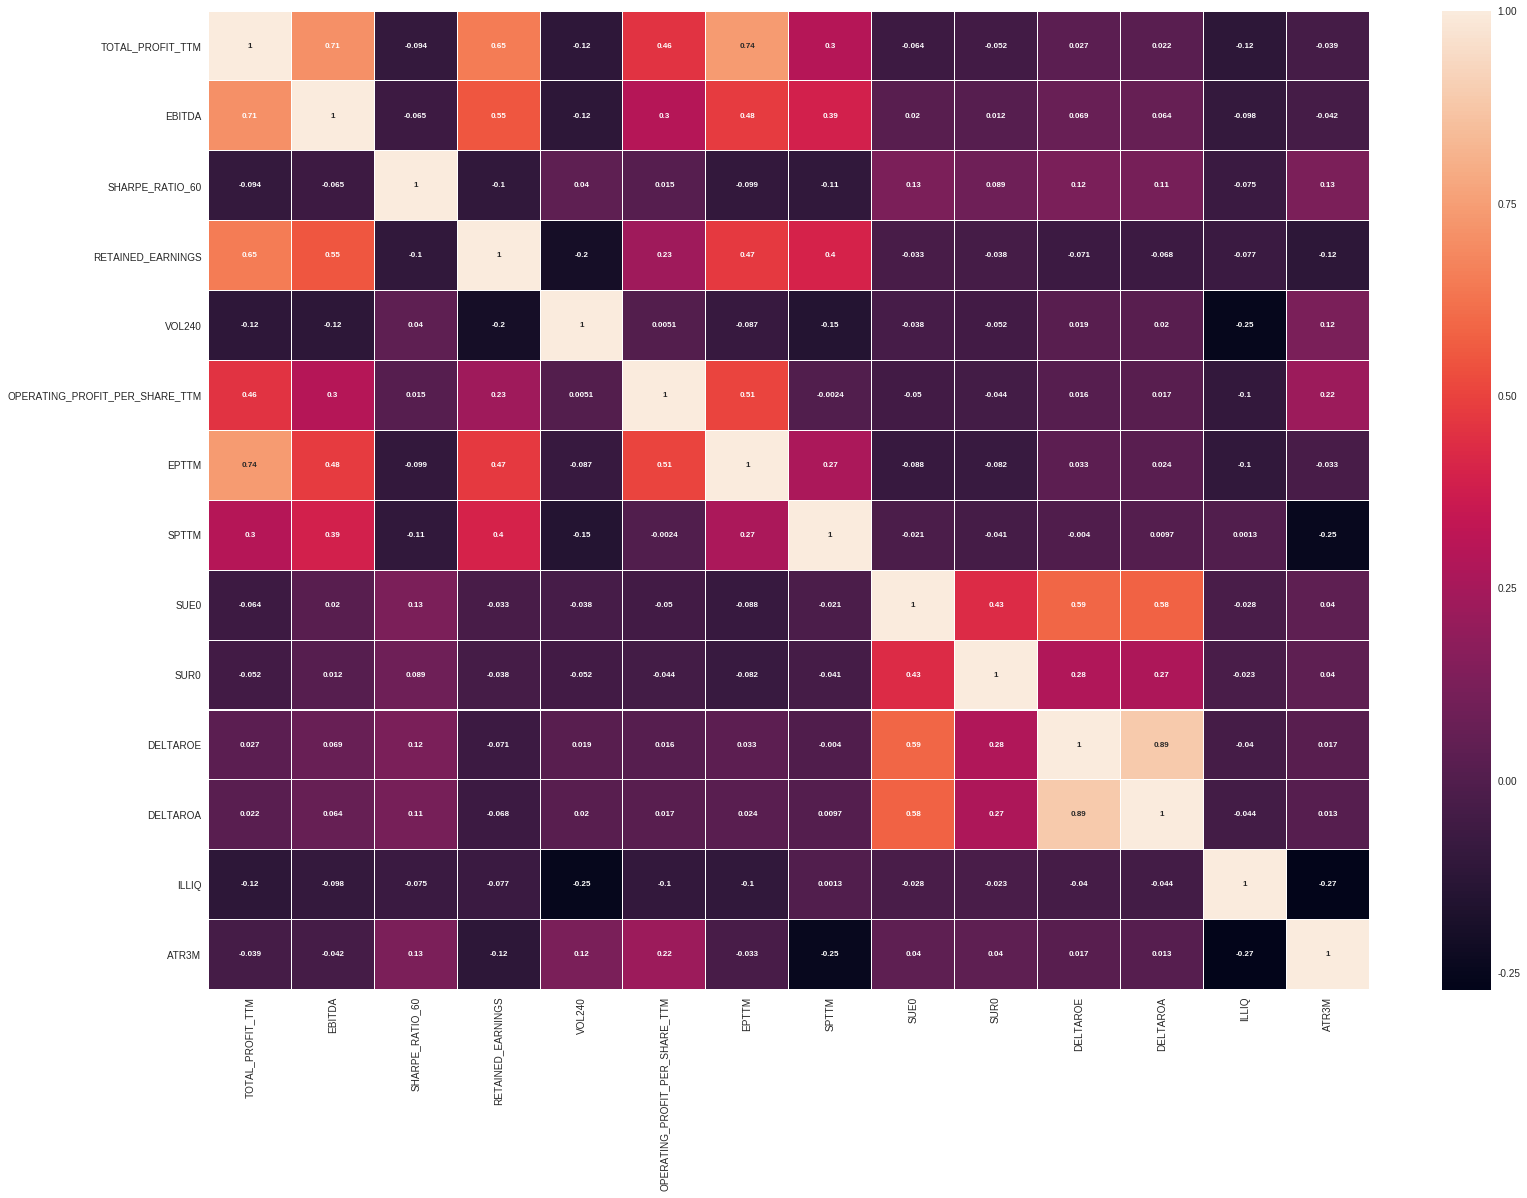

In [17]:
# 绘制因子正交前的相关性的热力图
fig = plt.figure(figsize=(26, 18))
# 计算对称正交之前的相关系数矩阵
relations = get_relations(factors4.iloc[:,:-2])  
sns.heatmap(relations, annot=True, linewidths=0.05,
            linecolor='white', annot_kws={'size': 8, 'weight': 'bold'})

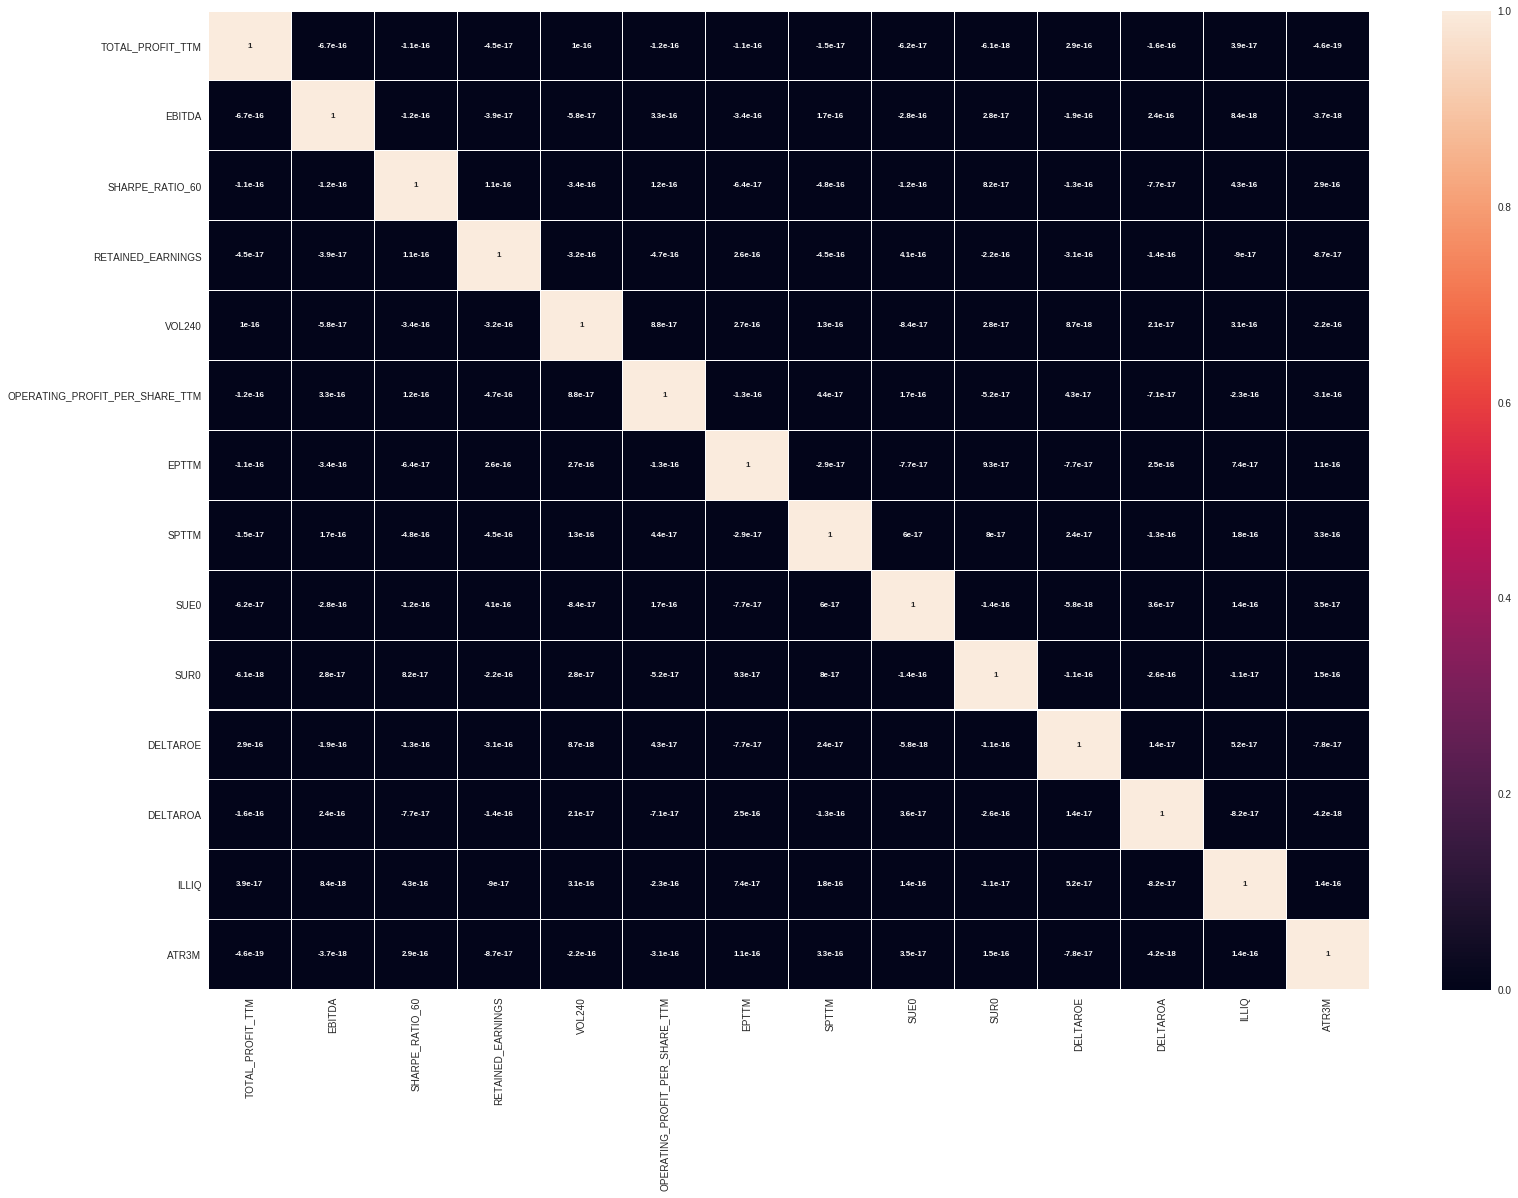

In [18]:
#绘制因子正交后的相关性热力图
fig=plt.figure(figsize=(26,18))
#计算对称正交之后的相关系数矩阵
relations= get_relations(factors5.iloc[:,:-2])  
sns.heatmap(relations,annot=True,linewidths=0.05,
            linecolor='white',annot_kws={'size':8,'weight':'bold'})

In [19]:
def get_next_ret(factor: pd.DataFrame, keep_last_term: bool = False, last_term_next_date: str = None) -> pd.Series:
    '''
    keep_last_term:是否保留最后一期数据
    last_term_next_date:如果keep_last_term=True,则此参数为计算最后一期下期收益时的截止时间,必须时交易日
    '''
    securities = factor.index.levels[1].tolist()  # 股票代码
    periods = [i.strftime('%Y-%m-%d') for i in factor.index.levels[0]]  # 日期

    if keep_last_term:
        end = last_term_next_date
        periods = periods + [end]

        if not end:
            raise ValueError('如果keep_last_term=True,则必须有last_term_next_date参数')

    close = pd.concat([get_price(securities, end_date=i, count=1, fields='close', panel=False)
                       for i in periods])

    close = pd.pivot_table(close, index='time', columns='code', values='close')
    ret = close.pct_change().shift(-1)
    ret = ret.iloc[:-1]
    return ret.stack()

In [20]:
# 获取下期收益率
next_ret = get_next_ret(factors5,True,'2023-10-14')

factors5['NEXT_RET'] = next_ret

In [21]:
# 根据IR计算因子权重

# step1:计算rank_IC

def calc_rank_IC(factor: pd.DataFrame) -> pd.DataFrame:

    factor_col = [x for x in factor.columns if x not in [
        'INDUSTRY_CODE', 'market_cap', 'NEXT_RET']]

    IC = factor.groupby(level='date').apply(lambda x: [st.spearmanr(
        x[factor], x['NEXT_RET'])[0] for factor in factor_col])
    
    return pd.DataFrame(IC.tolist(), index=IC.index, columns=factor_col)


## step2: 计算IR权重
def IR_weight(factor: pd.DataFrame) -> pd.DataFrame:

    data_ = factor.copy()
    # 计算ic值，得到ic的
    IC = calc_rank_IC(data_)
    
    # 计算ic的绝对值
    abs_IC = IC.abs()
    # rolling为移动窗口函数,滚动12个月
    rolling_ic = abs_IC.rolling(12, min_periods=1).mean()
    # 当滚动计算标准差时，起始日期得到的是缺失值，所以算完权重后，起始日期的值任用原值IC代替
    rolling_ic_std = abs_IC.rolling(12, min_periods=1).std()
    IR = rolling_ic / rolling_ic_std  # 计算IR值
    IR.iloc[0,:] = rolling_ic.iloc[0,:]
    weight = IR.div(IR.sum(axis=1), axis=0)  # 计算IR权重,按行求和,按列相除

    return weight

In [22]:
# 获取权重
weights = IR_weight(factors5)

In [23]:
# 获取因子名称
factor_names = [name for name in factors5.columns if name not in [
    'INDUSTRY_CODE', 'market_cap', 'NEXT_RET']]

# 计算因子分数
factors5['SCORE'] = (factors5[factor_names].mul(weights)).sum(axis=1)

In [24]:
factors5.head()


TOTAL_PROFIT_TTM    EBITDA    ...     NEXT_RET     SCORE
date       code                                       ...                       
2013-01-31 000001.XSHE          0.034737  0.031448    ...     0.090301  0.025066
           000002.XSHE          0.002102  0.042835    ...     0.000000  0.021907
           000009.XSHE         -0.035702  0.011758    ...    -0.061905 -0.008590
           000012.XSHE         -0.038058 -0.030826    ...    -0.002203 -0.022433
           000024.XSHE          0.044423  0.089546    ...    -0.018753  0.046134

[5 rows x 18 columns]

In [25]:
def get_weighs(symbol:str,start:str,end:str,method:str='cons')->pd.DataFrame:
    '''
    获取月度指数成份权重
    --------
        mehtod:ind 输出 行业权重
               cons 输出 成份股权重
    '''
    periods = GetTradePeriod(start, end, 'ME')
    
    ser_dic = {}
    if method == 'ind':
        for d in periods:

            # 获取当日成份及权重
            index_w = get_index_weights(symbol,date=d)
            # 获取行业
            index_w['ind'] = get_stock_ind(index_w.index.tolist(),d)
            # 计算行业所占权重
            weight = index_w.groupby('ind')['weight'].sum() / 100

            ser_dic[d] = weight

        ser = pd.concat(ser_dic,names=['date','industry']).reset_index()
        ser['date'] = pd.to_datetime(ser['date'])
        return ser.set_index(['date','industry'])
    
    elif method == 'cons':
        
        df = pd.concat([get_index_weights(symbol,date = d) for d in periods])
        df.drop(columns='display_name',inplace=True)
        
        df.set_index('date',append=True,inplace=True)
        df = df.swaplevel()
        df['weight'] = df['weight'] / 100
        return df
            


def get_group(ser:pd.Series,N:int=3,ascend:bool=True)->pd.Series:
    '''默认分三组 升序'''
    ranks = ser.rank(ascending=ascend)
    label = ['G'+str(i) for i in range(1,N + 1)]
    
    return pd.cut(ranks,bins= N,labels=label) 

In [26]:
def stratified_sampling(symbol: str, START_DATE: str, END_DATE: str, factors: pd.DataFrame) -> pd.DataFrame:
    
    factors_ = factors.copy()
    ind_weight = get_weighs(symbol, START_DATE, END_DATE)
    # 市值等量分三组
    k1 = [pd.Grouper(level='date'),
          pd.Grouper(key='INDUSTRY_CODE')]

    factors_['GROUP'] = factors_.groupby(
        k1)['market_cap'].apply(lambda x: get_group(x, 3))

    # 获取每组得分最大的
    k2 = [pd.Grouper(level='date'),
          pd.Grouper(key='INDUSTRY_CODE'),
          pd.Grouper(key='GROUP')]

    industry_kfold_stock = factors_.groupby(
        k2)['SCORE'].apply(lambda x: x.idxmax()[1])
    
    # 格式调整
    industry_kfold_stock = industry_kfold_stock.reset_index()
    industry_kfold_stock = industry_kfold_stock.set_index(['date', 'SCORE'])
    industry_kfold_stock.index.names = ['date', 'code']
    
    # 加入权重
    industry_kfold_stock['weight'] = ind_weight['weight']
    
    # 令权重加总为1
    industry_kfold_stock['w'] = industry_kfold_stock.groupby(
        level='date')['weight'].transform(lambda x: x / x.sum())
    
    industry_kfold_stock['NEXT_RET'] = factors['NEXT_RET']

    return industry_kfold_stock

In [27]:
# 获取分层数据
result_df = stratified_sampling('000300.XSHG', START_DATE, END_DATE, factors5[[
                                'INDUSTRY_CODE', 'market_cap', 'SCORE', 'NEXT_RET']])

In [28]:
# 储存,用于回测
result_df.to_csv('result_df.csv')
result_df.head()

INDUSTRY_CODE GROUP  weight         w  NEXT_RET
date       code                                                       
2013-01-31 000750.XSHE        801190    G1  0.0013  0.007888  0.016467
           601336.XSHG        801190    G2  0.0008  0.004854 -0.020246
           601166.XSHG        801190    G3  0.0275  0.166869 -0.002594
           000961.XSHE        801180    G1  0.0008  0.004854  0.020050
           600340.XSHG        801180    G2  0.0017  0.010316 -0.009141

In [29]:
# 根据result_df文件中生成的权重及股票名单进行回测
# 获取回测结果
gt = get_backtest('3b715e9e092c63a1c29e292192d172a7')

algorithm = pd.DataFrame(gt.get_results()).set_index('time')
algorithm['excess_returns'] = (
    algorithm['returns'] + 1) / (algorithm['benchmark_returns'] + 1) - 1

algorithm.index = pd.to_datetime(algorithm.index)
algorithm.head()

,benchmark_returns,returns,excess_returns
time,,,
2013-01-04 16:00:00,0.000579,0.0,-0.000578
2013-01-07 16:00:00,0.005169,0.0,-0.005142
2013-01-08 16:00:00,0.000943,0.0,-0.000942
2013-01-09 16:00:00,0.001260,0.0,-0.001259
2013-01-10 16:00:00,0.003020,0.0,-0.003011


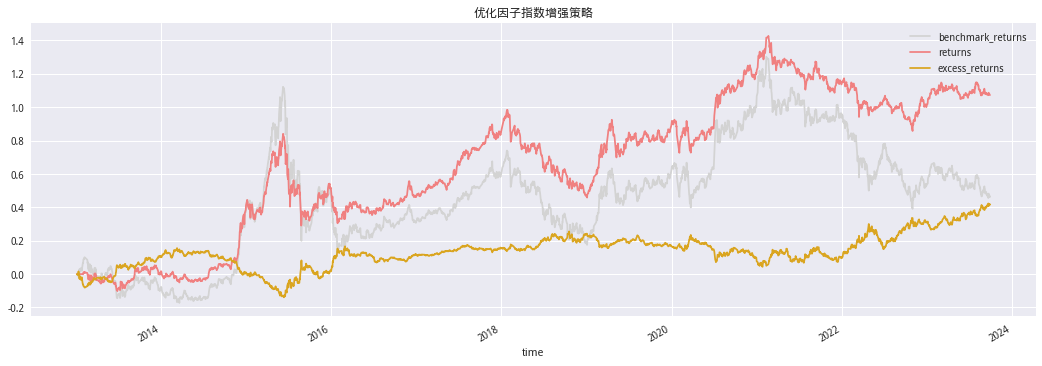

In [30]:
plt.rcParams['font.family'] = 'serif'
algorithm.plot.line(figsize=(18, 6), title='优化因子指数增强策略', color=[
                    'LightGrey', 'LightCoral', 'GoldenRod'])

In [31]:
# 风险指标如下
pd.Series(gt.get_risk()).iloc[1:]

algorithm_return                                      1.07238
algorithm_volatility                                 0.147669
alpha                                               0.0340777
annual_algo_return                                  0.0722351
annual_bm_return                                    0.0370468
avg_excess_return                                 0.000153051
avg_position_days                                     392.823
avg_trade_return                                    0.0646013
benchmark_return                                     0.462383
benchmark_volatility                                  0.22108
beta                                                 0.623912
day_win_ratio                                        0.508806
excess_return                                        0.417128
excess_return_max_drawdown                            0.25493
excess_return_max_drawdown_period    [2014-03-10, 2015-06-12]
excess_return_sharpe                               -0.0612941
informat